In [1]:
import numpy as np
import os, cv2
import h5py
import tifffile
from tqdm import tqdm, trange
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from deepreg.predict import unwrapped_predict, normalize_batched_image
from deepreg.model.layer import Warping
import tensorflow as tf
import matplotlib.pyplot as plt


batch_size = 8
label_shape = (30, 3)
irregular = True

2025-04-23 13:23:11.353481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 13:23:11.353523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 13:23:11.354851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Register a video in batches

In [2]:
# # tiff_path = "/store1/alicia/jellyfish/concat_cropped_0_11999.tif"
# tiff_path = "/storage/fs/store1/brian/swiming_videos/GREEN_FULL_LAB_DS/0-1999.tif"
# out_folder = "/storage/fs/store1/brian/swiming_videos/GREEN_FULL_LAB_DS/"

# tiff_path = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/20250214_Experiment_01_0-1999.tif"
# out_folder = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/"

# # tiff_path = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/fry_align.tif"

# tiff_path = "/home/brian/data4/brian/PBnJ/jelly_h5s/rig-align-BOTH.tif"
# out_folder = "/storage/fs/store1/brian/swiming_videos/Folder_20240930105926_good/"

tiff_path = "/home/brian/store1/brian/swiming_videos/Folder_20240930105926_good/RIG_20240930_0-1999.tif"
tiff_folder = "/home/brian/store1/brian/swiming_videos/Folder_20240930105926_good/"
out_folder = "/storage/fs/store1/brian/swiming_videos/Folder_20240930105926_good/"

# tiff_folder = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/"
# out_folder = tiff_folder


checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_again/save/ckpt-626"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_redo_DP/save/ckpt-396"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/long_first_jelly_redo_DP_real/save/ckpt-368"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/weights_shifted_2/save/ckpt-385"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_flat-TOOMUCHNORM2/save/ckpt-29"
# checkpoint_path = "~/store1/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_flat-TOOMUCHNORM2/save/ckpt-29"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/karen/save/ckpt-6"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/karen/save/ckpt-254"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_mvmt_bounded/save/ckpt-237"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_mvmt_bounded_2/save/ckpt-35"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_mvmt_bounded_4-bgfloor/save/ckpt-293"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_mvmt_bounded_6-log/save/ckpt-26"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/all_labs_mvmt_bounded_9-sing/save/ckpt-490"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_1-nolab/save/ckpt-999"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_2-imgpad_nl/save/ckpt-240"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_3-minpad/save/ckpt-126"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_4-waymore/save/ckpt-1771"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_4-waymore/save/ckpt-536"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_5-dataug/save/ckpt-87"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_6-dpda/save/ckpt-190"
# checkpoint_path = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/demo_notebook/RFa_6.1-cont/save/ckpt-688"

output_video_path = "/home/brian/data4/brian/PBnJ/out_vids/no_align.mp4"
log_dir = "/home/brian/data4/brian/PBnJ/out_vids/logs"


In [3]:
inputs = tifffile.imread(tiff_path)

In [4]:
inputs.shape

(2000, 2, 1200, 1200)

In [5]:
if(len(inputs.shape) == 3):
    irregular = False
    inputs = inputs[:, np.newaxis, ...]

In [6]:
crop_shape = np.array((1024, 1024))
# crop_shape = np.array((1080, 1080))

crop_offset = (inputs.shape[2:] - crop_shape) / 2
assert np.all(crop_offset == crop_offset.astype(int))
crop_offset = crop_offset.astype(int)

## Crop the images
inputs_crop = inputs[:, :, crop_offset[0]:crop_offset[0] + crop_shape[0], crop_offset[1]:crop_offset[1] + crop_shape[1]]
assert np.all(inputs_crop.shape[2:] == crop_shape)

In [7]:
if irregular:
    input_red = inputs_crop[:, 1, ...]
    input_green = inputs_crop[:, 0, ...]
else:
    input_red = inputs_crop[:, 0, ...]
    # input_green = inputs_crop[:, 1, ...]

In [8]:
if 'batched_fixed_image' not in locals():
    fixed_image_ARCHIVE = input_red[0] # So we don't have to reload stuff
    batched_fixed_image = np.repeat(np.expand_dims(input_red[0], axis=0), batch_size, axis=0).astype(np.float32)
    print("Fixed img saved")
else:
    batched_fixed_image = np.repeat(np.expand_dims(fixed_image_ARCHIVE, axis=0), batch_size, axis=0).astype(np.float32)
    print("Restored")

Fixed img saved


In [9]:
os.chdir("/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/scripts")
from register import set_GPU, register
# set_GPU(1)

In [10]:
#### FIRST WE'RE GOING TO JUST TRY TO ALIGN TO A SINGLE FRAME
## The first batch of good videos was aligned using ckpt-90, going to switch to 626

log_dir = "/home/brian/data4/brian/PBnJ/out_vids/logs"

config_path = os.path.join(checkpoint_path.split("/save")[0], "config.yaml")
model = None

# max_frames = 400
max_frames = 2000
# max_frames = 1000
# max_frames = 8
# side_len = 1080
side_len = 1024
red_offset = 0

red_chan = 1
other_chan = (red_chan - 1) % inputs.shape[1]

padding = np.array([[0,0],[0,0],[0,0],[1,0]])

# batched_fixed_image_pad = np.pad(batched_fixed_image[..., np.newaxis], padding, "constant", constant_values=0)
# batched_fixed_image = np.log2((batched_fixed_image - np.min(batched_fixed_image)) + 1, dtype=np.float32) #### TODO? Change sqrt?
batched_fixed_image_pad = np.pad(batched_fixed_image[..., np.newaxis], padding, "constant", constant_values=np.min(batched_fixed_image))
z_depth = 2
# batched_fixed_image_pad = np.repeat(batched_fixed_image[..., np.newaxis], z_depth, axis=-1)

warping = Warping(fixed_image_size=(side_len, side_len, 2), batch_size=batch_size)
# warping = Warping(fixed_image_size=(side_len, side_len, 2), batch_size=batch_size, interpolation="nearest")

# files = ["0-1999"]
# files = ["RIG_20240930_0-1999.tif", "RIG_20240930_2000-3999.tif", "RIG_20240930_4000-5999.tif"]
# files = ["CHAN_RIG_20240930_0-1999.tif", "CHAN_RIG_20240930_2000-3999.tif", "CHAN_RIG_20240930_4000-5999.tif"]
files = ["RIG_CHAN_20240930_0-1999.tif", "RIG_CHAN_20240930_2000-3999.tif", "RIG_CHAN_20240930_4000-5999.tif", "RIG_CHAN_20240930_6000-7999.tif", "RIG_CHAN_20240930_8000-9999.tif",
               "RIG_CHAN_20240930_10000-11999.tif", "RIG_CHAN_20240930_12000-13999.tif", "RIG_CHAN_20240930_14000-15999.tif", "RIG_CHAN_20240930_16000-17999.tif", "RIG_CHAN_20240930_18000-19999.tif",
               "RIG_CHAN_20240930_20000-21999.tif", "RIG_CHAN_20240930_22000-23999.tif", "RIG_CHAN_20240930_24000-25999.tif", "RIG_CHAN_20240930_26000-27999.tif", "RIG_CHAN_20240930_28000-29999.tif"]
# files = ["RIG_fry_align.tif"]
for file in files:
    inputs = tifffile.imread(os.path.join(tiff_folder, file))
    inputs_crop = inputs[:, :, crop_offset[0]:crop_offset[0] + crop_shape[0], crop_offset[1]:crop_offset[1] + crop_shape[1]]
    input_red = inputs_crop[:, red_chan, ...]
    input_green = inputs_crop[:, other_chan, ...]
    outs = np.zeros_like(inputs_crop)
    for frame in trange(0, max_frames, batch_size):
        if frame + batch_size > (max_frames):
            frame = (max_frames) - batch_size

        batched_moving_image = input_red[(frame - red_offset):(frame-red_offset)+batch_size].astype(np.float32)
        # batched_moving_image = np.log2((batched_moving_image - np.min(batched_moving_image)) + 1, dtype=np.float32)
        # batched_moving_image = np.pad(batched_moving_image[..., np.newaxis], padding, "constant", constant_values=0)
        batched_moving_image = np.pad(batched_moving_image[..., np.newaxis], padding, "constant", constant_values=np.min(batched_moving_image))
        # batched_moving_image = np.repeat(batched_moving_image[..., np.newaxis], z_depth, axis=-1)
        
        ddf_output, pred_fixed_image, model = unwrapped_predict(
            batched_fixed_image_pad,
            batched_moving_image,
            log_dir,
            label_shape,
            label_shape,
            model = model,
            model_ckpt_path = checkpoint_path,
            model_config_path = config_path,
        )

        gr_in = np.pad(input_green[(frame):(frame)+batch_size, ..., np.newaxis], padding, "constant", constant_values=0).astype(np.float32)
        outs[frame:(frame) + batch_size, other_chan] = warping(inputs=[ddf_output, gr_in]).numpy()[..., 1]
        
        batched_moving_image = input_red[(frame - red_offset):(frame-red_offset)+batch_size].astype(np.float32)
        batched_moving_image = np.pad(batched_moving_image[..., np.newaxis], padding, "constant", constant_values=0)
        outs[frame:(frame) + batch_size, red_chan] = warping(inputs=[ddf_output, batched_moving_image]).numpy()[..., 1]
        
        # outs[frame:(frame) + batch_size] = pred_fixed_image[..., 1] * 100
    # tifffile.imwrite(os.path.join(out_folder, "RED_WARPED_" + file), outs)

    tifffile.imwrite(os.path.join(out_folder, "WARPED-BOTH_" + file), outs, imagej=True, bigtiff=True)
    # break


  0%|          | 0/250 [00:00<?, ?it/s]

2025-04-23 13:32:11 | WARNING  | Log directory /home/brian/data4/brian/PBnJ/out_vids/logs exists already.
2025-04-23 13:32:11 | WARNING  | Using customized configuration. The code might break if the config doesn't match the saved model.
Built inputs.
Built control points.
Concatenated images.
{'extract_levels': ListWrapper([0, 1, 2, 3]), 'name': 'local', 'num_channel_initial': 16}
Built backbone.
Built DDF.
Built warping.


100%|██████████| 250/250 [15:56<00:00,  3.83s/it] 
/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:1753: UserWarning: <tifffile.TiffWriter 'WARPED-BOTH_RIG_…0930_0-1999.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(
100%|██████████| 250/250 [05:32<00:00,  1.33s/it]
/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:1753: UserWarning: <tifffile.TiffWriter 'WARPED-BOTH_RIG…30_2000-3999.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(
100%|██████████| 250/250 [06:10<00:00,  1.48s/it]
/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:1753: UserWarning: <tifffile.TiffWriter 'WARPED-BOTH_RIG…30_4000-5999.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(
100%|██████████| 250/250 [05:20<00:00,  1.28s/it]
/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:1753: UserWarning: <tifffile.TiffWriter 'WARPED-BOTH_RIG…30_6000-7999.tif'> writing nonconformant Big

In [11]:
outs[frame - offset:(frame - offset) + batch_size] = pred_fixed_image[..., 1] * 100
frame - offset

NameError: name 'offset' is not defined

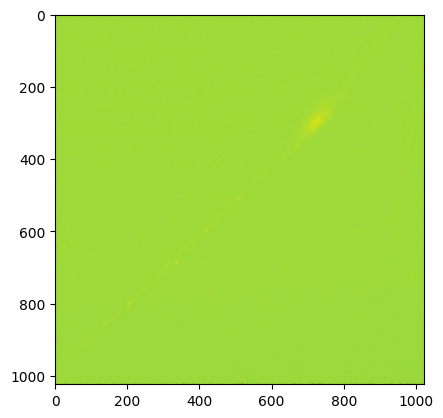

In [ ]:
%matplotlib inline
# plt.imshow(pred_fixed_image[0,...,1])
# plt.imshow(batched_moving_image[0,...,1])
plt.imshow(outs[384])
plt.show()

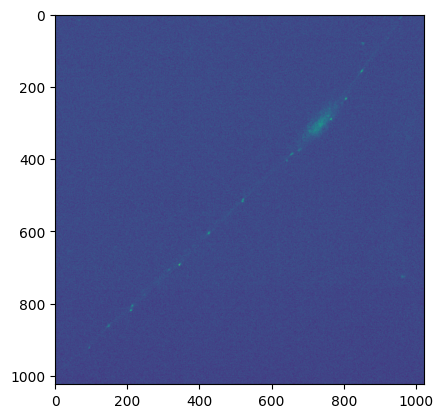

In [ ]:
# warping(inputs=[ddf_output, gr_in])


plt.imshow(batched_moving_image[0, ..., 1])
# plt.imshow(gr_in[0, ..., 1], alpha=0.1, cmap="jet")
# plt.imshow(gr_in[0, ..., 1])

In [ ]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = outs

fig = plt.figure()
im = plt.imshow(video[0,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:])

def animate(i):
    im.set_data(video[i,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=max_frames,
                               interval=20)
HTML(anim.to_html5_video())